# **Import Dataset**


## 1A) Dataset from Google Drive
Email: fintecch@gmail.com\
Password: fintech12345678

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#for unmounting only dont run!
drive.flush_and_unmount()

## 1B) Dataset from repo

In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
dataset = "creditcard.csv"
dataset_path = path_parent + "/Dataset/data/" + dataset
print("Dataset path:{}".format(dataset_path))

Dataset path:/Users/chengjunlam/Desktop/Github local repos/ML_Fraud_Detection_X_BNPP/Dataset/data/creditcard.csv


# **Code and Data Exploration**

## **1) Pre-Processing**
- Main aim of this step is to convert all data fields to numerical for calculation of Euclidean Distance, which is the main focus for SVDD

In [2]:
#importing packages and dataset/visualize dataset
import pandas as pd
from sklearn import preprocessing
df = pd.read_csv(dataset_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Preparing train and test data
- Split X and Y
- Split fraud and non-fraud data

In [3]:
#splitting X and Y
X = df.iloc[:, :-1]
Y = df['Class']
#splitting fraud and non-fraud X
X['Class'] = df['Class']
X_nonFraud = X.loc[df['Class'] == 0]
X_Fraud = X.loc[df['Class'] == 1]
X_nonFraud = X_nonFraud.iloc[:, :-1]
X_Fraud = X_Fraud.iloc[:, :-1]
print("Number of non fraud: {}".format(X_nonFraud.shape[0]))
print("Number of fraud: {}".format(X_Fraud.shape[0]))
#setting train test set
#test set contains entire dataset
#train set contains non-fraud data
#no need for y_train as not used
X_test = X.iloc[:, : -1]
y_test = df['Class']
X_train = X_nonFraud

Number of non fraud: 284315
Number of fraud: 492


### Normalistaion of numerical data
- normalize X_test
- normalize X_train

In [4]:
#normalize both X 
X_test = pd.DataFrame(preprocessing.normalize(X_test))
X_train = pd.DataFrame(preprocessing.normalize(X_train))

## 2) Reduction of data points using DBSCAN and REDBSCAN


### Helper functions

In [5]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
#for cluster optics
#cluster labels: -1 means anomoly, positive numbers represent cluster each pt belongs to
#dataframe columns to have x and y as labels for the 2 features
#inputs data: only to contain 2 features for now, numpy array input type
#inputs eps: max distance between each pt to regard as same cluster
def DBSCAN(data,eps):
  start = time.time()
  print("Starting DBSCAN...")
  clustering_optics = OPTICS(eps = eps, cluster_method = 'dbscan').fit(data)
  end = time.time()
  print("DBSCAN DONE")
  print("Time taken for DBSCAN: {} seconds".format(end-start))
  cluster_labels = clustering_optics.labels_
  df_dbscan = np.column_stack((data,cluster_labels))
  df_dbscan = pd.DataFrame(df_dbscan,columns = ['x','y','labels'])
  df_dbscan['labels'] = df_dbscan['labels'].astype(int)
  return df_dbscan

#feature_data is the from original data, input type numpy array 
#labels is the labels found from DBSCAN
#eps is the max distance from each pt to sample
#percent is selection of top proportion with highest distance calculated
def REDBSCAN(feature_data,labels,eps,percent):
  print("Starting REDBSCAN...")
  start = time.time()
  boundary_pts = []
  dropped = []
  counter = 0
  for index, x in enumerate(feature_data):
    if index in dropped:
      continue
    counter +=1
    dist, dropped_pts = findTotalDistance(x,feature_data,labels,labels[index],eps)
    boundary_pts.append({
        'pt': x,
        'dist': dist
    })
    boundary_pts.sort(key = lambda x: x['dist'], reverse = True)
    df_reduced_pts = formatReducedPts(boundary_pts,percent)
    for i in dropped_pts:
      if i not in dropped:
        dropped.append(i)
  print(counter)
  end = time.time()
  print("REDBSCAN DONE")
  print("Time taken: {} s".format(end-start))
  return df_reduced_pts

def findTotalDistance(pt,data,labels,cluster,eps):
  distance = 0
  no_pts = 0
  rank = {}
  for index, x in enumerate(data):
    if labels[index] == cluster:
      dist = np.linalg.norm(pt-x)
      if dist <= eps:
        distance += dist
        no_pts += 1
        rank[index] = dist
  {k: v for k, v in sorted(rank.items(), key=lambda item: item[1])}
  dropped_pts = [*rank]
  dropped_pts = dropped_pts[:int(0.2*len(dropped_pts))]
  return distance/no_pts, dropped_pts

def formatReducedPts(reduced_pts,percent):
  length_pts = len(reduced_pts)
  selected_pts = reduced_pts[:int(length_pts*percent)]
  #dropped_pts = reduced_pts[int(length_pts*percent):]
  #dropped_pts = [x['index'] for x in dropped_pts]
  points = [d['pt'] for d in selected_pts]
  df_reduced_pts = pd.DataFrame(points)
  #optional step
  #df_reduced_pts.columns = ['x','y']
  return df_reduced_pts

### Implementation of DBSCAN and REDBSCAN

Selecting 2 features manually for testing and validation purposes

In [30]:
#select number of samples to reduce computational time
#select 2 features only for visualization purposes
no_of_samples = 2000
feature_columns = [1,3]
#filter X dataset
X_train_selected = X_train[X_train.columns[feature_columns[0]:feature_columns[1]]]
X_train_selected.columns = ['x', 'y']
X_train_selected = X_train_selected.to_numpy()
X_train_selected = X_train_selected[:no_of_samples]

Running DBSCAN and visualising data

Starting DBSCAN...
DBSCAN DONE
Time taken for DBSCAN: 1.233384132385254 seconds


/opt/anaconda3/envs/BNPP-Fintech/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.1, 0.25)

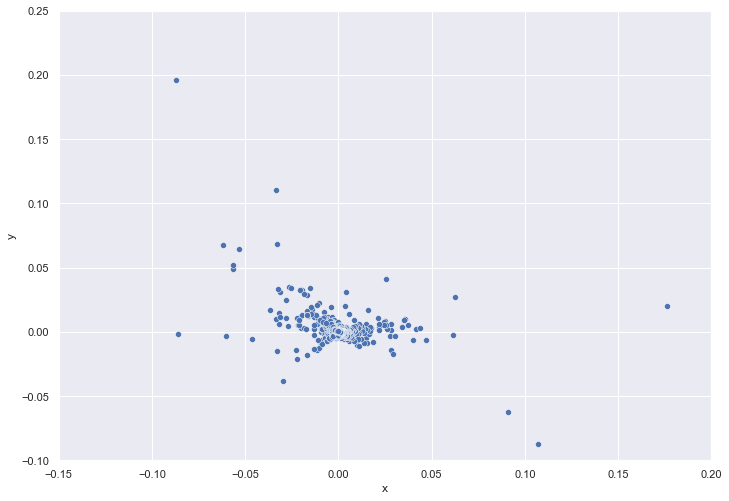

In [31]:
#run DBSCAN
#input dataset is a numpy array 
X_train_selected_dbscan = DBSCAN(X_train_selected, 0.02)
#visualisation
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(X_train_selected_dbscan["x"], X_train_selected_dbscan["y"], palette=sns.color_palette("tab10",X_train_selected_dbscan['labels'].nunique())).plot()
ax.set_xlim(-0.15,0.2)
ax.set_ylim(-0.10,0.25)

Implementing REDBSCAN
<br>
<br>Note that this function implements Euclidean Distance and works for 2 dimensions (2 features) for more than 2 dimensions, a different method need to be applied.
<br>
<br> eps: Currently at 0.02 increasing eps will underfit the reduction and include more anomoly pts. decreasing eps will overfit the reduction and include less anomoly pts
<br>
<br> percent: Currently at 0.20 increasing percent will retain more of the original pts. decreasing percent will retain less of the original pts.

In [8]:
#running REDBSCAN
#converting features to numpy array
X_train_selected_dbscan_pts = X_train_selected_dbscan.iloc[:, 0:2].values
X_train_selected_reduced = REDBSCAN(X_train_selected_dbscan_pts,X_train_selected_dbscan['labels'],eps = 0.01,percent = 0.10)

Starting REDBSCAN...
1503
REDBSCAN DONE
Time taken: 36.3564977645874 s


/opt/anaconda3/envs/BNPP-Fintech/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.1, 0.25)

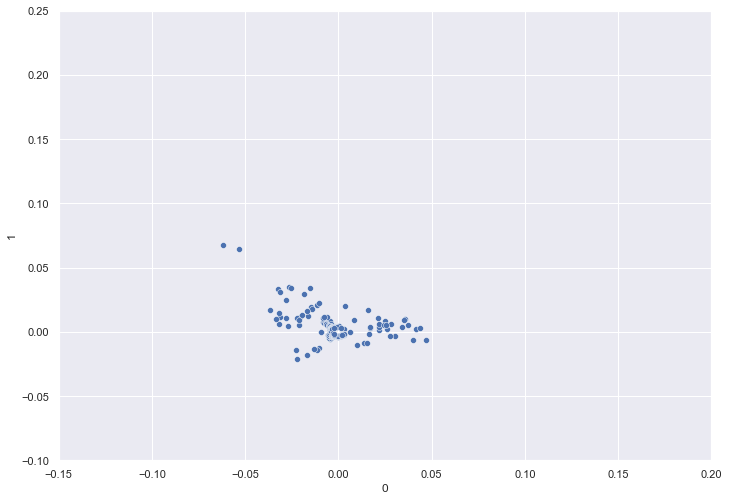

In [9]:
#visualisation of final reduced data
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(X_train_selected_reduced[0], X_train_selected_reduced[1]).plot()
ax.set_xlim(-0.15,0.2)
ax.set_ylim(-0.10,0.25)

## 3) Implementing SVDD

In [10]:
#OneClassSVM with rbf kernal is similar to svdd
from sklearn.svm import OneClassSVM 
training_pts_toList = X_train_selected_reduced.values.tolist()
#X_train_ = X_train.to_numpy()
start = time.time()
svm = OneClassSVM(kernel='rbf', gamma=0.001) 
svm.fit(training_pts_toList)
print("time taken: {}".format(time.time()-start))
print("number of datapoints:{}".format(len(training_pts_toList)))

time taken: 0.0015361309051513672
number of datapoints:150


In [11]:
#predicting test data for validation
start = time.time()
X_test_selected = X_test[X_test.columns[feature_columns[0]:feature_columns[1]]]
# X_test_selected.columns = ['x', 'y']
# X_test_selected = X_train_selected.to_numpy()
y_pred = svm.predict(X_test_selected) 
y_pred = np.where(y_pred == -1, 1,0)
print("time taken: {}".format(time.time()-start))

time taken: 1.9684360027313232


/opt/anaconda3/envs/BNPP-Fintech/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.1, 0.25)

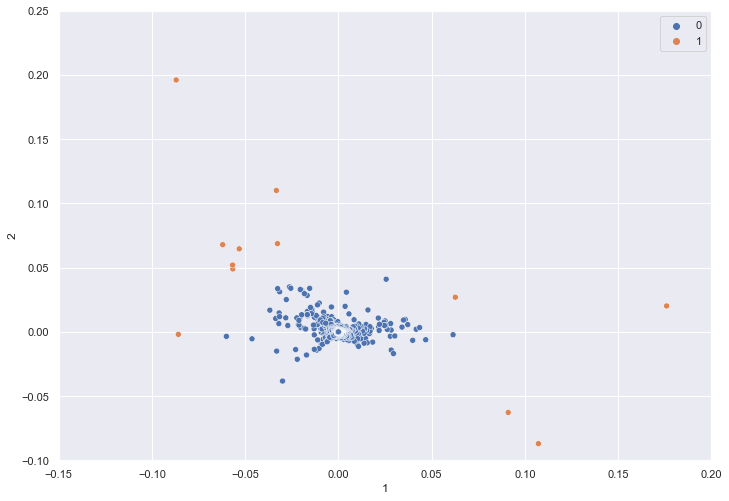

In [22]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(X_test_selected[1], X_test_selected[2], hue = y_pred).plot()
ax.set_xlim(-0.15,0.2)
ax.set_ylim(-0.10,0.25)

In [15]:
from sklearn.metrics import classification_report
print("Number of fraud detected: {}".format(np.count_nonzero(y_pred == 1)))
print("Actual fraud labels: {}".format(np.count_nonzero(y_test == 1)))
print(classification_report(y_test, y_pred))

Number of fraud detected: 14
Actual fraud labels: 492
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



## 4) Conclusion

- Number of samples used to reduce data points and train SVDD does not matter as much
- The hyperparameters of SVDD matters; only gamma needs to be manually changed; bigger gamma leads to a smaller red area (aka more points identified as anomoly); vice versa NEED TO DECIDE HOW TO DEAL WITH IT
- For REDBSCAN hyperparameters, the ones suggested above is good enough


-----------------

# Overall Class implementation


For implementation to actual python files

Note that this is to detect anomoly using 2 features, and not overall accuracy of fraud vs non-fraud.

Thus, classification report or confusion matrix is not an accurate representation of performance.

## 1) Class function to be implemented

In [23]:
from sklearn.cluster import OPTICS
import numpy as np
import time
from sklearn.svm import OneClassSVM 

"""
1. AnomolyDetection(eps,percent,gamma) - initialise the hyperparameters
    - eps: maximum distance between each point to consider for REDBSCAN
    - percent: proportion of datapoints to keep (e.g. 0.2 to keep 20% of the data)
    - gamma: coefficient for SVDD rbf kernel
    - Drop_rate: rate of points to drop while reducing data

2. reduce() - reduce the data points based on hyperparameters set in 1.

3. fit(data) - reduce, fit and train the data provided
    - note that the reduction of datapoints is done already
    - no option to remove the reduction of datapoints step as it is too computationally expensive

4. predict(data) - predict incoming data based on trained SVDD model
    - can be dataframe, but must be a series
"""
class AnomolyDetection():

  #set data and hyperparameters
  def __init__(self,eps = 0.01, percent = 0.10, gamma = 0.01, drop_rate = 0.2):
    self.data = None
    self.eps = eps
    self.percent = percent
    self.gamma = gamma
    self.svm = None
    self.drop_rate = drop_rate
    self.feature_columns = None
  
  #reduce data points using REDBSCAN algo
  def reduce(self):
    print("="*50)
    print("="*17 + "Reducing data" + "="*20)
    print("="*50)
    #select data based on input parameters
    if self.feature_columns:
      data_selected = self.data.iloc[:,self.feature_columns[0]:self.feature_columns[1]].to_numpy()
    else:
      data_selected = self.data.to_numpy()
    #run DBSCAN
    df_dbscan_labels = self.DBSCAN(data_selected, 0.02)
    #running REDBSCAN
    reduced_pts = self.REDBSCAN(data_selected,df_dbscan_labels,self.eps,self.percent,self.drop_rate)
    return reduced_pts

  #fit svdd with reduced points
  def fit(self,data, feature_columns = None):
    print("Anomoly Detection: eps = {}, percent = {}, gamma = {}, drop_rate = {}".format(self.eps,self.percent,self.gamma,self.drop_rate))
    if feature_columns:
      print("Selected feature columns: column {} to column {}".format(feature_columns[0],feature_columns[1]))
    else:
      print("All feature columns to be used")
    start = time.time()
    self.feature_columns = feature_columns
    self.data = data
    #reduce points with redbscan
    reduced_pts = self.reduce()
    #svdd training
    print("="*50)
    print("="*17 + "Training SVDD" + "="*20)
    print("="*50)
    print("Starting SVDD training...")
    svdd_start = time.time()
    training_pts_toList = reduced_pts.values.tolist()
    svm = OneClassSVM(kernel='rbf', gamma=self.gamma) 
    svm.fit(training_pts_toList)
    self.svm = svm
    end = time.time()
    print("SVDD training done")
    print("SVDD time taken:{}".format(end-svdd_start))
    print("="*50)
    print("Total Time taken: {}".format(end-start))
  
  #predict data
  # 1 is non fraud, -1 is fraud
  def predict(self,data, feature_columns = None):
    if feature_columns:
      return self.svm.predict(data.iloc[:,feature_columns[0]:feature_columns[1]])
    else:
      return self.svm.predict(data)

  #get input feature columns the model was trained on
  def get_trained_features(self):
    return self.feature_columns

  def DBSCAN(self,data,eps):
    start = time.time()
    print("Starting DBSCAN...")
    clustering_optics = OPTICS(eps = eps, cluster_method = 'dbscan').fit(data)
    end = time.time()
    print("DBSCAN DONE")
    print("Time taken for DBSCAN: {} seconds".format(end-start))
    cluster_labels = clustering_optics.labels_
    #df_dbscan = np.column_stack((data,cluster_labels))
    #df_dbscan = pd.DataFrame(df_dbscan,columns = ['x','y','labels'])
    #df_dbscan['labels'] = df_dbscan['labels'].astype(int)
    labels = cluster_labels.astype(int)
    return labels

  #feature_data is the from original data, input type numpy array 
  #labels is the labels found from DBSCAN
  #eps is the max distance from each pt to sample
  #percent is selection of top proportion with highest distance calculated

  def REDBSCAN(self,feature_data,labels,eps,percent,drop_rate):
    print("Starting REDBSCAN...")
    start = time.time()
    boundary_pts = []
    dropped = []
    counter = 0
    for index, x in enumerate(feature_data):
      if index in dropped:
        continue
      counter +=1
      dist, dropped_pts = self.findTotalDistance(x,feature_data,labels,labels[index],eps,drop_rate)
      boundary_pts.append({
          'pt': x,
          'dist': dist
      })
      boundary_pts.sort(key = lambda x: x['dist'], reverse = True)
      df_reduced_pts = self.formatReducedPts(boundary_pts,percent)
      for i in dropped_pts:
        if i not in dropped:
          dropped.append(i)
    end = time.time()
    print("REDBSCAN DONE")
    print("Time taken: {} s".format(end-start))
    return df_reduced_pts

  def findTotalDistance(self,pt,data,labels,cluster,eps,drop_rate):
    distance = 0
    no_pts = 0
    rank = {}
    for index, x in enumerate(data):
      if labels[index] == cluster:
        dist = np.linalg.norm(pt-x)
        if dist <= eps:
          distance += dist
          no_pts += 1
          rank[index] = dist
    {k: v for k, v in sorted(rank.items(), key=lambda item: item[1])}
    dropped_pts = [*rank]
    dropped_pts = dropped_pts[:int(drop_rate*len(dropped_pts))]
    return distance/no_pts, dropped_pts

  def formatReducedPts(self,reduced_pts,percent):
    length_pts = len(reduced_pts)
    selected_pts = reduced_pts[:int(length_pts*percent)]
    #dropped_pts = reduced_pts[int(length_pts*percent):]
    #dropped_pts = [x['index'] for x in dropped_pts]
    points = [d['pt'] for d in selected_pts]
    df_reduced_pts = pd.DataFrame(points)
    #optional step
    #df_reduced_pts.columns = ['x','y']
    return df_reduced_pts


## 2) Class usage

In [24]:
import pandas as pd
from sklearn import preprocessing

In [25]:
# pre-processing data into fraud and non-fraud
df = pd.read_csv(dataset_path)
df_features = df.iloc[:, :-1]
df_normalized = pd.DataFrame(preprocessing.normalize(df_features))
df_normalized['Class'] = df['Class']
df_nonFraud = df_normalized.loc[df['Class'] == 0]
df_Fraud = df_normalized.loc[df['Class'] == 1]
print("Number of non fraud: {}".format(df_nonFraud.shape[0]))
print("Number of fraud: {}".format(df_Fraud.shape[0]))

Number of non fraud: 284315
Number of fraud: 492


In [26]:
#setting train and test data
df_features_nonFraud = df_nonFraud.iloc[:, :-1]
df_features_Fraud = df_Fraud.iloc[:, :-1]
df_features_all = df.iloc[:, : -1]
#test set will contain all data
#training set will only contain non-fraud data
#no y_train as all training data assumed to be non-fraud
X_test = df_features_all
y_test = df['Class']
X_train = df_features_nonFraud

In [28]:
#preparing train and test data
no_of_samples = 10000
feature_columns = [0,31]
#selected number of train data for training
X_train_selected = X_train[:no_of_samples]
#training and prediction
anomoly_detection = AnomolyDetection()
anomoly_detection.fit(X_train_selected, feature_columns)

Anomoly Detection: eps = 0.01, percent = 0.1, gamma = 0.01, drop_rate = 0.2
Selected feature columns: column 0 to column 31
=================Reducing data====================
Starting DBSCAN...
DBSCAN DONE
Time taken for DBSCAN: 18.370903968811035 seconds
Starting REDBSCAN...
REDBSCAN DONE
Time taken: 639.3462920188904 s
=================Training SVDD====================
Starting SVDD training...
SVDD training done
SVDD time taken:0.020560026168823242
Total Time taken: 657.7418341636658


## 3) Validation

In [ ]:
#evaluation using test data
y_pred = anomoly_detection.predict(X_test, feature_columns)
print("Number of fraud detected: {}".format(np.count_nonzero(y_pred == -1)))
print("Actual fraud labels: {}".format(df_features_Fraud.shape[0]))

Number of fraud detected: 284807
Actual fraud labels: 492


In [ ]:
from sklearn.metrics import classification_report
#reformat y_pred
y_pred[y_pred == -1] = 0
y_pred[y_pred == 1] = 1
print(classification_report(actual_labels[:no_of_samples].values, y_pred))

ValueError: ignored

## 4) Visualisation of results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[]

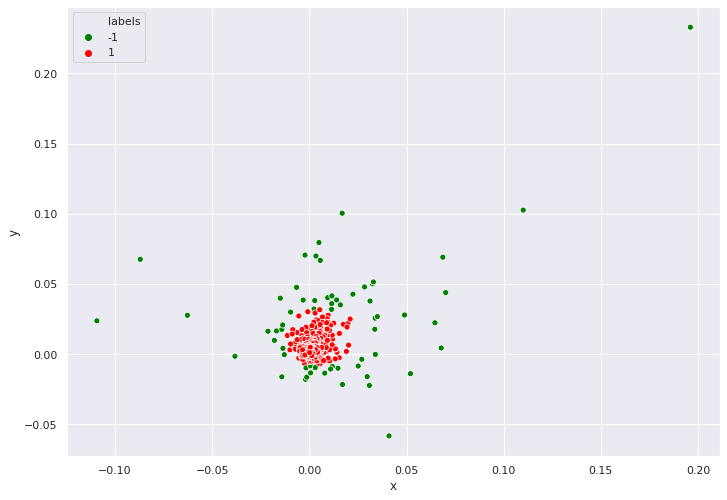

In [ ]:
#visualisation for comparison purposes 
#original dbscan data
import seaborn as sns
import matplotlib.pyplot as plt
df_selected_features_nonFraud = df_train[df_train.columns[feature_columns[0]:feature_columns[1]]]
df_selected_features_nonFraud.columns = ['x','y']
df_results_visualise_nonFraud = df_selected_features_nonFraud
df_results_visualise_nonFraud['labels'] = y_pred_nonFraud
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots()
sns.scatterplot(df_results_visualise_nonFraud["x"], df_results_visualise_nonFraud["y"], hue = df_results_visualise_nonFraud['labels'],palette=['green','red']).plot()


# ax.set_xlim(-0.005,0.005)
# ax.set_ylim(-0.005,0.005)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                  x             y         labels
count  2.848070e+05  2.848070e+05  284807.000000
mean   5.688174e-16 -8.769071e-15      -0.999712
std    1.651309e+00  1.516255e+00       0.023995
min   -7.271573e+01 -4.832559e+01      -1.000000
25%   -5.985499e-01 -8.903648e-01      -1.000000
50%    6.548556e-02  1.798463e-01      -1.000000
75%    8.037239e-01  1.027196e+00      -1.000000
max    2.205773e+01  9.382558e+00       1.000000


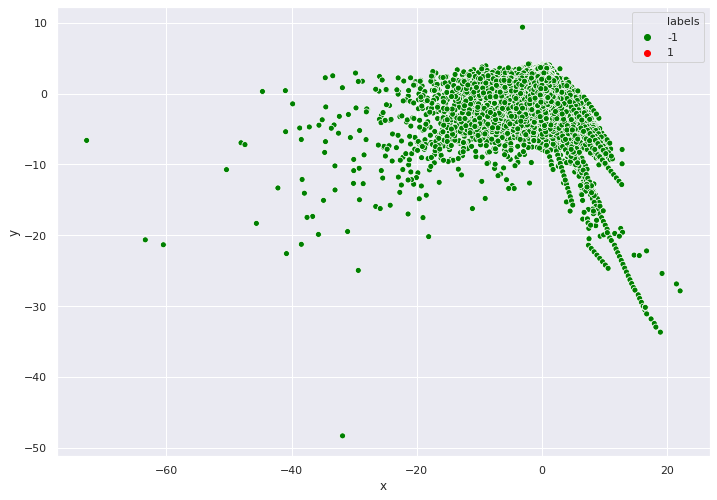

In [ ]:
df_selected_features_all = df_features_all[df_features_all.columns[feature_columns[0]:feature_columns[1]]]
df_selected_features_all.columns = ['x','y']
df_results_visualise_all = df_selected_features_all
df_results_visualise_all['labels'] = y_pred_all
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots()
sns.scatterplot(df_results_visualise_all["x"], df_results_visualise_all["y"], hue = df_results_visualise_all['labels'],palette=['green','red']).plot()
print(df_selected_features_all.describe())



## 5) Computational time
- No significant computational time on SVDD (only tested small samples size due to reduction of datapoints using REDBSCAN)
- Significant computational time on REDBSCAN 
- No significant computational time on DBSCAN

-------------
# Zi Ping Code

In [ ]:
def reDBSCAN(feature_data,labels,eps):
  reduced_pts = []
  unique_cluster = np.unique(labels)
  boundary_pts = []
  for cluster in unique_cluster:
    for index, x in  enumerate(feature_data):
      if labels[index] == cluster:
        dist = findTotalDistance(x,feature_data,labels,cluster,eps)
        boundary_pts.append({
            'pt': x,
            'dist': dist,
            'cluster': cluster
        })
      else:
        pass
    print(boundary_pts)
    boundary_pts.sort(key = lambda x: x['dist'], reverse = True)
    length_pts = len(boundary_pts)
  return boundary_pts

def findTotalDistance(pt,data,labels,cluster,eps):
  distance = 0
  no_pts = 0
  for index, x in enumerate(data):
    if labels[index] == cluster:
      dist = np.linalg.norm(pt-x)
      if dist <= eps:
        distance += dist
        no_pts += 1
  return distance/no_pts

In [ ]:
def REDBSCAN(feature_data,labels,eps,percent):
  print("Starting REDBSCAN...")
  start = time.time()
  boundary_pts = []
  dropped = []
  counter = 0
  for index, x in enumerate(feature_data):
    if index in dropped:
      continue
    counter +=1
    dist, dropped_pts = findTotalDistance(x,feature_data,labels,labels[index],eps)
    boundary_pts.append({
        'pt': x,
        'dist': dist
    })
    boundary_pts.sort(key = lambda x: x['dist'], reverse = True)
    df_reduced_pts = formatReducedPts(boundary_pts,percent)
    for i in dropped_pts:
      if i not in dropped:
        dropped.append(i)
  print(counter)
  end = time.time()
  print("REDBSCAN DONE")
  print("Time taken: {} s".format(end-start))
  return df_reduced_pts

def findTotalDistance(pt,data,labels,cluster,eps):
  distance = 0
  no_pts = 0
  rank = {}
  for index, x in enumerate(data):
    if labels[index] == cluster:
      dist = np.linalg.norm(pt-x)
      if dist <= eps:
        distance += dist
        no_pts += 1
        rank[index] = dist
  {k: v for k, v in sorted(rank.items(), key=lambda item: item[1])}
  dropped_pts = [*rank]
  dropped_pts = dropped_pts[:int(0.2*len(dropped_pts))]
  return distance/no_pts, dropped_pts

def formatReducedPts(reduced_pts,percent):
  length_pts = len(reduced_pts)
  selected_pts = reduced_pts[:int(length_pts*percent)]
  #dropped_pts = reduced_pts[int(length_pts*percent):]
  #dropped_pts = [x['index'] for x in dropped_pts]
  points = [d['pt'] for d in selected_pts]
  df_reduced_pts = pd.DataFrame(points)
  #optional step
  #df_reduced_pts.columns = ['x','y']
  return df_reduced_pts

(-0.1, 0.25)

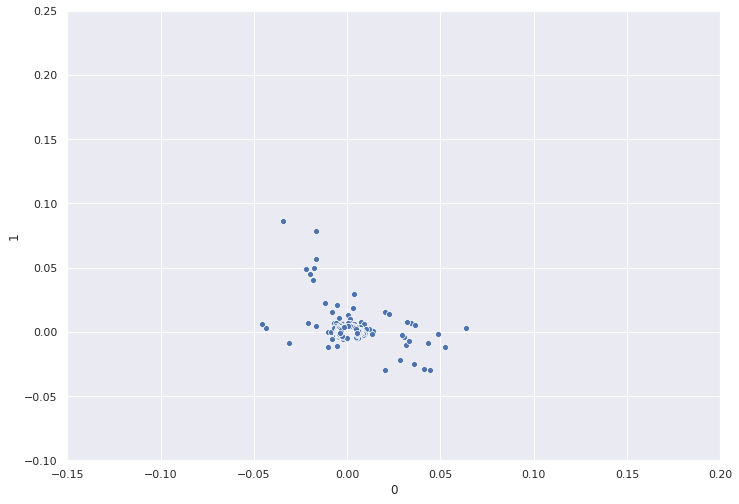

In [ ]:
#visualisation of final reduced data
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(reduced_pts[0], reduced_pts[1]).plot()
ax.set_xlim(-0.15,0.2)
ax.set_ylim(-0.10,0.25)

(-0.1, 0.25)

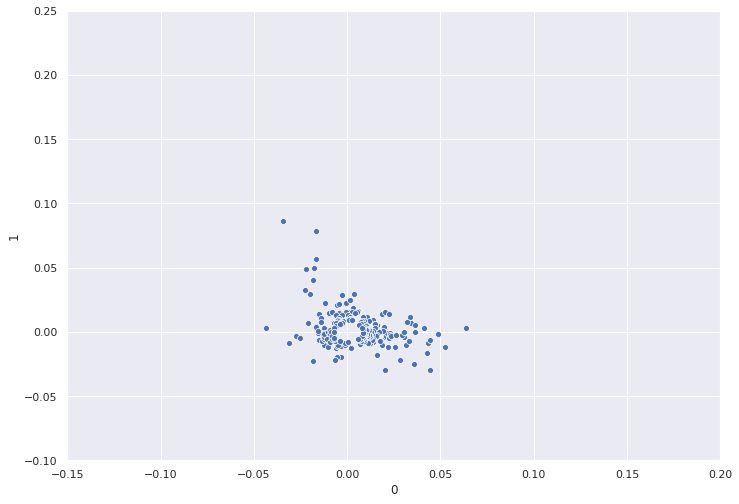

In [ ]:
#visualisation of final reduced data
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(reduced_pts[0], reduced_pts[1]).plot()
ax.set_xlim(-0.15,0.2)
ax.set_ylim(-0.10,0.25)

In [ ]:
for (intercept, coef) in zip(svm.intercept_, svm.coef_):
    s = "y = {0:.3f}".format(intercept)
    for (i, c) in enumerate(coef):
        s += " + {0:.3f} * x{1}".format(c, i)
    print(s)

AttributeError: ignored

In [ ]:
x = df_dbscan.iloc[:, 0:2].values
start = time.time()
reduced_pts = reDBSCAN(x,df_dbscan['labels'],0.2,0.02)
end = time.time()
print("Time taken: {} s".format(end-start))

[{'pt': array([-0.00048627,  0.01694613]), 'dist': 0.016131099834421674, 'cluster': 0}, {'pt': array([-0.00353876,  0.00468223]), 'dist': 0.005815613287528438, 'cluster': 0}, {'pt': array([-0.00149885,  0.01450896]), 'dist': 0.01386568365927503, 'cluster': 0}, {'pt': array([0.01251955, 0.02209006]), 'dist': 0.015445447856387655, 'cluster': 0}, {'pt': array([0.02017726, 0.00649245]), 'dist': 0.01828687495337029, 'cluster': 0}, {'pt': array([0.03387815, 0.02566922]), 'dist': 0.010827938841340826, 'cluster': 0}, {'pt': array([ 0.0030572, -0.0012093]), 'dist': 0.0038361670720494815, 'cluster': 0}, {'pt': array([-0.01001414,  0.0031472 ]), 'dist': 0.010677159230210488, 'cluster': 0}, {'pt': array([0.009642  , 0.02776804]), 'dist': 0.013795531838996011, 'cluster': 0}, {'pt': array([-0.0054369 ,  0.02723253]), 'dist': 0.01523173158567199, 'cluster': 0}, {'pt': array([-0.00586223,  0.00443049]), 'dist': 0.007400928665135313, 'cluster': 0}, {'pt': array([ 0.00854262, -0.00445983]), 'dist': 0.00

In [ ]:
length_pts = len(reduced_pts)
boundary_pts = reduced_pts[:int(length_pts*0.01)]
print(length_pts)

5000


In [ ]:
final_pts = {}
x = []
y = []
z = []
for pts in boundary_pts:
  x.append(pts["pt"][0])
  y.append(pts["pt"][1])
  z.append(pts["cluster"])
final_pts['x'] = x
final_pts['y'] = y
final_pts['z'] = z

In [ ]:
len(final_pts)

3

In [ ]:
reduced_df = pd.DataFrame(final_pts)
reduced_df.head(3)

,x,y,z
0,0.009171,0.017906,0
1,0.010363,0.016974,0
2,-0.018020,0.009882,0


(-0.05, 0.25)

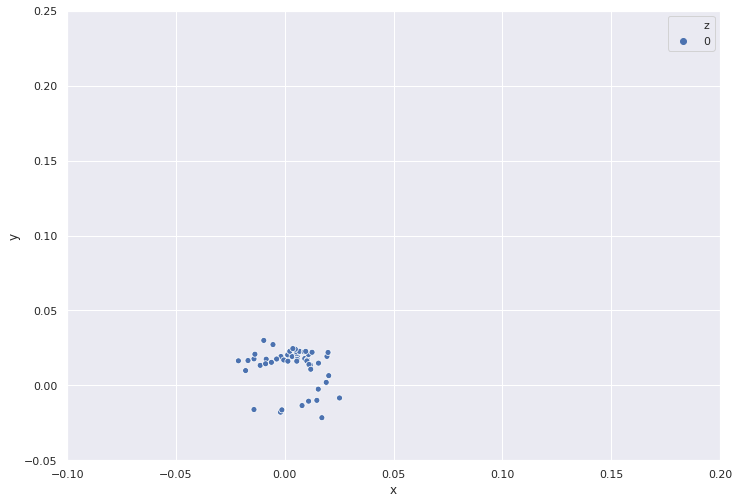

In [ ]:
#visualisation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(reduced_df["x"], reduced_df["y"], hue = reduced_df['z']).plot()
ax.set_xlim(-0.1,0.2)
ax.set_ylim(-0.05,0.25)

[]

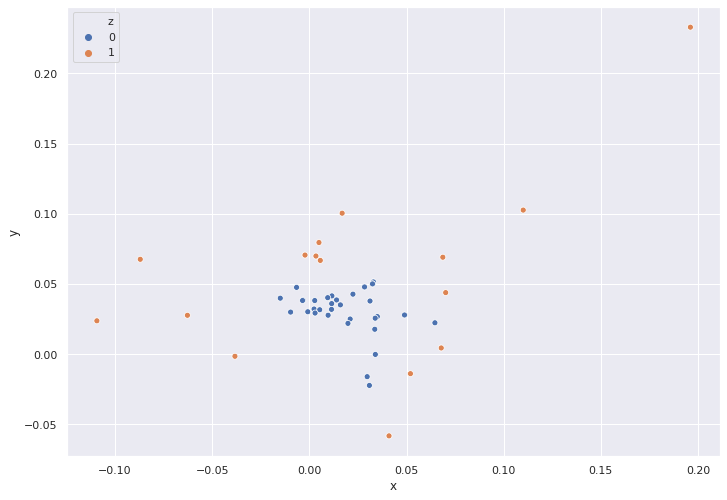

In [ ]:
#visualisation
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(reduced_df["x"], reduced_df["y"], hue = reduced_df['z']).plot()

In [ ]:
X = reduced_df.drop('z', axis=1)

In [ ]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto').fit(X)

In [ ]:
''